### 왼, 오, 위, 아래를 한 픽셀 이동하는 함수 생성
### 이 후 훈련 세트에 위 함수를 적용하여 테스트 세트에서 모델 정확성 측정

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)

In [3]:
import numpy as np
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int)

X.shape, y.shape

((70000, 784), (70000,))

In [4]:
train_test_idx = 60000
X_train, X_test, y_train, y_test = X[:train_test_idx], X[train_test_idx:], y[:train_test_idx], y[train_test_idx:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

In [5]:
shuffled_idx = np.random.permutation(train_test_idx)

In [6]:
X_train, y_train = X_train[shuffled_idx], y_train[shuffled_idx]
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [7]:
def move_img_pixel(train_data, label_data, pixel=1, aug=5):
    """
    각 위, 아래, 오른쪽, 왼쪽에 대해 데이터 증강 진행
    픽셀을 움직일 때 잘리는 부분 버림, 보존하는 경우가 데이터 학습에 더 좋은 영향을 끼치지 않기 때문
    """
    N = len(train_data)
    vector = len(train_data[0]) # 1차원 길이
    wh = int(vector**0.5)
    move_pixel = wh * pixel # 1 픽셀: width(==height) 크기
    move_X_train = np.zeros((N*5, vector))
    move_y_train = np.zeros((N*5, 1))
    
    background = np.zeros(move_pixel)
    for i, (img_data, img_label) in enumerate(zip(train_data, label_data)):
        idx = i*aug
        reshape_img = img_data.reshape(wh, wh)
        move_X_train[idx] = img_data
        move_X_train[idx+1] = np.append(img_data, background)[move_pixel:]
        move_X_train[idx+2] = np.append(background, img_data)[:-move_pixel]
        move_X_train[idx+3] = np.append(reshape_img.T, background)[move_pixel:].reshape(wh,wh).T.flatten()
        move_X_train[idx+4] = np.append(background, reshape_img.T)[:-move_pixel].reshape(wh,wh).T.flatten()
        
        move_y_train[idx: idx+5] = img_label
        
    return move_X_train, move_y_train

In [8]:
X_train_move, y_train_move = move_img_pixel(X_train, y_train, 5)

In [9]:
import matplotlib
import matplotlib.pyplot as plt


def mnist_imshow(imgs):
    wh = int(len(imgs[0]) ** 0.5) # 1차원 벡터에서 2차원 벡터 크기 계산
    row = len(imgs)
    reshape_imgs = [img.reshape(wh, wh) for img in imgs]
    row_images = np.concatenate(reshape_imgs, axis=1)
    plt.imshow(row_images, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

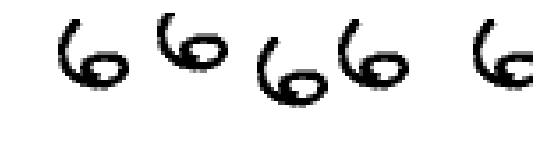

In [10]:
mnist_imshow(X_train_move[:5])

In [11]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_train_minmax = minmax_scaler.fit_transform(X_train.astype(np.float64))
X_test_minmax = minmax_scaler.transform(X_test.astype(np.float64))

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def random_forest_score(train_data, test_data):
    # 예제 1번에서 찾은 하이퍼파라미터 값 적용, n_estimators=150
    forest_clf = RandomForestClassifier(n_estimators=150, random_state=42)
    forest_clf.fit(*train_data)
    forest_clf_score = forest_clf.score(*test_data)
    return forest_clf_score


def kneighbors_score(train_data, test_data):
    # 예제 1번에서 찾은 하이퍼파라미터 값 적용, n_neighbors=3, weights=distance
    knn_clf = KNeighborsClassifier(n_neighbors=3, weights="distance")
    knn_clf.fit(*train_data)
    knn_score = knn_clf.score(*test_data)
    return knn_score

In [13]:
def get_maximum_score(model_type, Xy_train_data, Xy_test_data):
    if model_type == "random_forest":
        get_model_score = random_forest_score
    elif model_type == "knn":
        get_model_score = kneighbors_score
    else:
        return
    
    max_score = [0, 0]
    
    shuffle_idx = np.random.permutation(len(X_train)*5) # 동일한 비교를 위해
    for px in [1, 3, 5]:
        X_train_moved, y_train_moved = move_img_pixel(*Xy_train_data, px)
        X_train_moved = X_train_moved[shuffle_idx]
        y_train_moved = y_train_moved[shuffle_idx]
        
        score = get_model_score((X_train_moved, y_train_moved), Xy_test_data)
        if max_score[1] < score:
            max_score[0] = px
            max_score[1] = score
        print(f"move_pixel: {px}, score: {score}")

        del X_train_moved
        del y_train_moved

    print(f"max_score move pixel: {max_score[0]}, score: {max_score[1]}")

# 예제 2번 성능 테스트

**px 이동에 따른 성능은 px 이동이 커질수록 성능 하락**

test set은 정중앙에 숫자가 위치하고 있기에, px을 더 많이 움직여 중앙을 벗어날수록 성능 하락

### 1. random forest 0.9711(예제 1번 성능) -> 0.9804 성능 증진

In [17]:
get_maximum_score("random_forest", (X_train_minmax, y_train), (X_test_minmax, y_test))

move_pixel: 1, score: 0.9804
move_pixel: 3, score: 0.9718
move_pixel: 5, score: 0.9688
max_score move pixel: 1, score: 0.9804


### 2. knn 0.9717(예제 1번 성능) -> 0.9763 성능 증진 (1px 이동 기준)

In [18]:
get_maximum_score("knn", (X_train_minmax, y_train), (X_test_minmax, y_test))

move_pixel: 1, score: 0.9763
move_pixel: 3, score: 0.9689
move_pixel: 5, score: 0.9703
max_score move pixel: 1, score: 0.9763
